In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
from datetime import date
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearnex import patch_sklearn
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
import warnings

## Traffic data
The traffic data that is imported here is taken from the **TrafficDataCleaning file**, where detailed steps about the cleaning of the dataset have been specified as well as a data dictionary with data requirements. 
### Importing the data

In [2]:
traffic_data = pd.read_csv("datasets/CleanTraffic.csv")
traffic_data.sample(3)

,TrafficJamNum,StartDate,EndDate,StartTime,EndTime,Severity,Length,Duration,HectometerStart,HectometerEnd,...,CauseCodeDescr,CauseClass,CauseCodeClass,CauseCode,Cause_1,Cause_2,Cause_3,Cause_4,StartDateTime,EndDateTime
331774,3297575,2022-11-29,2022-11-29,7:28:27,7:30:02,3.483,2200.0,1.583,24.1,26.3,...,Spitsfile (geen oorzaak gemeld),[Geen oorzaakcode opgegeven door VWM 2],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2022-11-29 07:28:27,2022-11-29 07:30:02
184103,3833056,2023-11-20,2023-11-20,7:48:28,7:52:01,10.097,2844.0,3.550,24.3,21.5,...,Spitsfile (geen oorzaak gemeld),[Geen oorzaakcode opgegeven door VWM 4],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2023-11-20 07:48:28,2023-11-20 07:52:01
318264,3267973,2022-11-10,2022-11-10,16:12:28,16:19:01,14.892,2274.0,6.550,31.8,34.1,...,Spitsfile (geen oorzaak gemeld),[Geen oorzaakcode opgegeven door VWM 7],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2022-11-10 16:12:28,2022-11-10 16:19:01


In [3]:
traffic_data.shape

(1714882, 28)

### Checking the data types and missing values

In [4]:
traffic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1714882 entries, 0 to 1714881
Data columns (total 28 columns):
 #   Column               Dtype  
---  ------               -----  
 0   TrafficJamNum        int64  
 1   StartDate            object 
 2   EndDate              object 
 3   StartTime            object 
 4   EndTime              object 
 5   Severity             float64
 6   Length               float64
 7   Duration             float64
 8   HectometerStart      float64
 9   HectometerEnd        float64
 10  RoadLetter           object 
 11  RoadNumber           int64  
 12  RoadDescr            object 
 13  HectometerDirection  object 
 14  RoadSectionFrom      object 
 15  RoadSectionTo        object 
 16  MainRoadFrom         object 
 17  MainRoadTo           object 
 18  CauseCodeDescr       object 
 19  CauseClass           object 
 20  CauseCodeClass       object 
 21  CauseCode            object 
 22  Cause_1              object 
 23  Cause_2              object 
 24

In [5]:
traffic_data.isna().sum()

TrafficJamNum          0
StartDate              0
EndDate                0
StartTime              0
EndTime                0
Severity               0
Length                 0
Duration               0
HectometerStart        0
HectometerEnd          0
RoadLetter             0
RoadNumber             0
RoadDescr              0
HectometerDirection    0
RoadSectionFrom        0
RoadSectionTo          0
MainRoadFrom           0
MainRoadTo             0
CauseCodeDescr         0
CauseClass             0
CauseCodeClass         0
CauseCode              0
Cause_1                0
Cause_2                0
Cause_3                0
Cause_4                0
StartDateTime          0
EndDateTime            0
dtype: int64

It can be concluded that the file got imported correctly and is ready to be used further.

### Altering data
#### Adding hour

In [6]:
traffic_data['Hour'] = traffic_data['StartTime'].apply(lambda x: x.split(':')[0]).astype(int)
traffic_data.sample(3)

,TrafficJamNum,StartDate,EndDate,StartTime,EndTime,Severity,Length,Duration,HectometerStart,HectometerEnd,...,CauseClass,CauseCodeClass,CauseCode,Cause_1,Cause_2,Cause_3,Cause_4,StartDateTime,EndDateTime,Hour
523616,3039128,2022-05-20,2022-05-20,18:16:27,18:19:00,3.570,1400.0,2.550,3.2,4.6,...,[Geen oorzaakcode opgegeven door VWM 3],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2022-05-20 18:16:27,2022-05-20 18:19:00,18
1577728,2384528,2018-07-24,2018-07-24,16:53:00,16:54:51,3.700,2000.0,1.850,52.4,54.4,...,[Geen oorzaakcode opgegeven door VWM 2],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2018-07-24 16:53:00,2018-07-24 16:54:51,16
1224378,2174111,2017-06-15,2017-06-15,17:12:00,17:18:58,13.933,2000.0,6.967,117.7,115.7,...,[Geen oorzaakcode opgegeven door VWM 7],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2017-06-15 17:12:00,2017-06-15 17:18:58,17


#### Keeping only relevant roads

As we want to only have the specific roads that our client can possibly use to reach the offices, we will prepare the data for joining by filtering on the roads A2 and A73.
An important observation is that **A2 leads from Sittard to 's-Hertogenbosch** and vice versa, whereas **A73 leads from Sittard to Boxmeer** and vice versa. Other routes are also possible, but they are significantly slower. Therefore, it is better to focus on those two only for now. Furthermore, they have been suggested by the client as the optimal routes.

In [7]:
filtered_traffic= traffic_data[(traffic_data['RoadDescr'] == 'A73') | (traffic_data['RoadDescr'] == 'A2')]
filtered_traffic.shape

(209047, 29)

#### Subsetting the roads to contain only road sections beween relevant cities
In order to come up with the correct hectometer markers, we consulted the https://www.hmpaal.nl/. We came up with the right answers by using a map with the relevant roads and performing a trial and error search for the correct markers. That is not the best approach, however, since at the moment the markers have been hardcoded in the filtering, which makes a potential expansion of the model impossible without further changes.

In [8]:
filtered_a2 = filtered_traffic[
    (filtered_traffic['RoadDescr'] == 'A2') &
    (filtered_traffic['HectometerStart'] >= 111) &
    (filtered_traffic['HectometerStart'] <= 235)
]

filtered_a73 = filtered_traffic[
    (filtered_traffic['RoadDescr'] == 'A73') &
    (filtered_traffic['HectometerStart'] >= 0) &
    (filtered_traffic['HectometerStart'] <= 83)
]

# Combine the filtered data into a single DataFrame
filtered_traffic = pd.concat([filtered_a2, filtered_a73])

# Display a sample of 3 rows from the combined DataFrame
filtered_traffic.sample(3)

,TrafficJamNum,StartDate,EndDate,StartTime,EndTime,Severity,Length,Duration,HectometerStart,HectometerEnd,...,CauseClass,CauseCodeClass,CauseCode,Cause_1,Cause_2,Cause_3,Cause_4,StartDateTime,EndDateTime,Hour
591257,3932702,2024-02-05,2024-02-05,7:18:26,7:22:00,7.300,2047.0,3.567,164.3,166.4,...,[Geen oorzaakcode opgegeven door VWM 4],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2024-02-05 07:18:26,2024-02-05 07:22:00,7
547474,3050810,2022-05-30,2022-05-30,8:17:27,8:20:02,5.265,2038.0,2.583,164.3,166.3,...,[Geen oorzaakcode opgegeven door VWM 3],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2022-05-30 08:17:27,2022-05-30 08:20:02,8
549739,3698944,2023-09-04,2023-09-04,16:06:28,16:21:58,45.278,2921.0,15.500,172.3,174.3,...,"[Geen oorzaakcode opgegeven door VWM 1], [Defe...","[000], [HBD]",HBD,Defecte vrachtwagen(s),Defecte vrachtwagen,Incident (gestrand voertuig),Incident,2023-09-04 16:06:28,2023-09-04 16:21:58,16


### Making the direction numerical
0 = Morning (Sittard - Den Bosch)

1 = Afternoon (Den Bosch - Sittard)

In [9]:
warnings.filterwarnings('ignore')
filtered_traffic.loc[filtered_traffic["HectometerDirection"]=="oplopend", 'HectometerDirectionNum'] = 1
filtered_traffic.loc[filtered_traffic["HectometerDirection"]=="aflopend", 'HectometerDirectionNum'] = 0

filtered_traffic.sample(3)

,TrafficJamNum,StartDate,EndDate,StartTime,EndTime,Severity,Length,Duration,HectometerStart,HectometerEnd,...,CauseCodeClass,CauseCode,Cause_1,Cause_2,Cause_3,Cause_4,StartDateTime,EndDateTime,Hour,HectometerDirectionNum
495429,3219615,2022-10-12,2022-10-12,8:55:28,8:57:00,3.68,2400.0,1.533,164.4,166.8,...,[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2022-10-12 08:55:28,2022-10-12 08:57:00,8,0.0
1246004,2410291,2018-09-27,2018-09-27,17:27:00,17:29:30,5.00,2000.0,2.500,171.4,169.4,...,[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2018-09-27 17:27:00,2018-09-27 17:29:30,17,1.0
447386,3079064,2022-06-16,2022-06-16,7:10:24,7:12:00,3.52,2200.0,1.600,164.5,166.7,...,[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2022-06-16 07:10:24,2022-06-16 07:12:00,7,0.0


### Removing useless columns

In [10]:
numerical_columns = filtered_traffic.select_dtypes(include=['int64', 'float64', 'int32'])
desired_columns = ["StartDate", "Duration", "RoadNumber", "Hour", "HectometerDirectionNum"]
selected_columns = filtered_traffic.loc[:, desired_columns]
selected_columns['StartDate'] = pd.to_datetime(selected_columns['StartDate'])
selected_columns.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69433 entries, 43 to 1714645
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   StartDate               69433 non-null  datetime64[ns]
 1   Duration                69433 non-null  float64       
 2   RoadNumber              69433 non-null  int64         
 3   Hour                    69433 non-null  int32         
 4   HectometerDirectionNum  69433 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1)
memory usage: 2.9 MB


### Summarising the duration per hour
This approach has been dropped for now as it requires a lot more thought and time for testing and further exploration.

In [11]:
# selected_columns = selected_columns.groupby(['StartDate', 'RoadNumber', 'Hour', 'HectometerDirectionNum']).sum().reset_index()
# selected_columns.head()

## Calendar

In [12]:
def create_date_table2(start, end):
    date_range = pd.date_range(start=start, end=end, freq='h')
    df = pd.DataFrame({"DateTime": date_range})
    df["StartDate"] = df["DateTime"].dt.date
    df["Hour"] = df["DateTime"].dt.hour
    return df

calendar = create_date_table2(start='2015-01-01', end=selected_columns['StartDate'].max())
calendar = calendar.drop(calendar.columns[0], axis=1)
calendar['StartDate'] = pd.to_datetime(calendar['StartDate'])
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82705 entries, 0 to 82704
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   StartDate  82705 non-null  datetime64[ns]
 1   Hour       82705 non-null  int32         
dtypes: datetime64[ns](1), int32(1)
memory usage: 969.3 KB


### Join road A2 and direction 1

In [13]:
a2d1 = selected_columns[(selected_columns['RoadNumber']==2)&(selected_columns['HectometerDirectionNum']==1)]
a2d1.sample(2)

,StartDate,Duration,RoadNumber,Hour,HectometerDirectionNum
633923,2023-07-15,18.583,2,12,1.0
509668,2022-10-24,1.567,2,16,1.0


In [14]:
mergedoutera2d1 = pd.merge(calendar, a2d1, how='left', on=['StartDate', 'Hour'])
mergedoutera2d1.isna().sum()

StartDate                     0
Hour                          0
Duration                  73877
RoadNumber                73877
HectometerDirectionNum    73877
dtype: int64

In [15]:
mergedoutera2d1['Duration'] = mergedoutera2d1['Duration'].fillna(0)
mergedoutera2d1['RoadNumber'] = mergedoutera2d1['RoadNumber'].fillna(2)
mergedoutera2d1['HectometerDirectionNum'] = mergedoutera2d1['HectometerDirectionNum'].fillna(1)
mergedoutera2d1.isna().sum()

StartDate                 0
Hour                      0
Duration                  0
RoadNumber                0
HectometerDirectionNum    0
dtype: int64

In [16]:
mergedoutera2d1.sample(2)

,StartDate,Hour,Duration,RoadNumber,HectometerDirectionNum
58649,2021-02-14,17,0.0,2.0,1.0
42679,2019-06-08,7,0.0,2.0,1.0


### Join road A2 and direction 0

In [17]:
a2d0 = selected_columns[(selected_columns['RoadNumber']==2)&(selected_columns['HectometerDirectionNum']==0)]
a2d0.sample(2)

,StartDate,Duration,RoadNumber,Hour,HectometerDirectionNum
1419747,2019-01-08,6.533,2,9,0.0
1050209,2018-11-21,7.567,2,6,0.0


In [18]:
mergedoutera2d0 = pd.merge(calendar, a2d0, how='left', on=['StartDate', 'Hour'])
mergedoutera2d0.isna().sum()

StartDate                     0
Hour                          0
Duration                  71737
RoadNumber                71737
HectometerDirectionNum    71737
dtype: int64

In [19]:
mergedoutera2d0['Duration'] = mergedoutera2d0['Duration'].fillna(0)
mergedoutera2d0['RoadNumber'] = mergedoutera2d0['RoadNumber'].fillna(2)
mergedoutera2d0['HectometerDirectionNum'] = mergedoutera2d0['HectometerDirectionNum'].fillna(0)
mergedoutera2d0.isna().sum()

StartDate                 0
Hour                      0
Duration                  0
RoadNumber                0
HectometerDirectionNum    0
dtype: int64

In [20]:
mergedoutera2d0.sample(2)

,StartDate,Hour,Duration,RoadNumber,HectometerDirectionNum
42540,2019-02-18,9,0.0,2.0,0.0
14076,2016-05-19,22,0.0,2.0,0.0


### Join A73 and direction 1

In [21]:
a73d1 = selected_columns[(selected_columns['RoadNumber']==73)&(selected_columns['HectometerDirectionNum']==1)]
a73d1.sample(2)

,StartDate,Duration,RoadNumber,Hour,HectometerDirectionNum
88480,2024-05-14,3.55,73,8,1.0
26410,2024-03-28,52.55,73,17,1.0


In [22]:
mergedoutera73d1 = pd.merge(calendar, a73d1, how='left', on=['StartDate', 'Hour'])
mergedoutera73d1.isna().sum()

StartDate                     0
Hour                          0
Duration                  80812
RoadNumber                80812
HectometerDirectionNum    80812
dtype: int64

In [23]:
mergedoutera73d1['Duration'] = mergedoutera73d1['Duration'].fillna(0)
mergedoutera73d1['RoadNumber'] = mergedoutera73d1['RoadNumber'].fillna(73)
mergedoutera73d1['HectometerDirectionNum'] = mergedoutera73d1['HectometerDirectionNum'].fillna(1)
mergedoutera73d1.isna().sum()

StartDate                 0
Hour                      0
Duration                  0
RoadNumber                0
HectometerDirectionNum    0
dtype: int64

In [24]:
mergedoutera73d1.sample(2)

,StartDate,Hour,Duration,RoadNumber,HectometerDirectionNum
70421,2022-12-17,12,0.0,73.0,1.0
34322,2018-11-30,20,0.0,73.0,1.0


### Join A73 and direction 0

In [25]:
a73d0 = selected_columns[(selected_columns['RoadNumber']==73)&(selected_columns['HectometerDirectionNum']==0)]
a73d0.sample(2)

,StartDate,Duration,RoadNumber,Hour,HectometerDirectionNum
883846,2022-07-29,2.517,73,16,0.0
94432,2024-05-24,412.533,73,11,0.0


In [26]:
mergedoutera73d0 = pd.merge(calendar, a73d0, how='left', on=['StartDate', 'Hour'])
mergedoutera73d0.isna().sum()

StartDate                     0
Hour                          0
Duration                  81177
RoadNumber                81177
HectometerDirectionNum    81177
dtype: int64

In [27]:
mergedoutera73d0['Duration'] = mergedoutera73d0['Duration'].fillna(0)
mergedoutera73d0['RoadNumber'] = mergedoutera73d0['RoadNumber'].fillna(73)
mergedoutera73d0['HectometerDirectionNum'] = mergedoutera73d0['HectometerDirectionNum'].fillna(0)
mergedoutera73d0.isna().sum()

StartDate                 0
Hour                      0
Duration                  0
RoadNumber                0
HectometerDirectionNum    0
dtype: int64

In [28]:
mergedoutera73d0.sample(2)

,StartDate,Hour,Duration,RoadNumber,HectometerDirectionNum
58662,2021-09-09,12,0.0,73.0,0.0
29194,2018-04-30,21,0.0,73.0,0.0


### Appending the 4 dataframes

In [29]:
dataframes = [mergedoutera2d0, mergedoutera2d1, mergedoutera73d0, mergedoutera73d1]
appended_frame = pd.concat(dataframes, axis=0)
appended_frame.isna().sum()

StartDate                 0
Hour                      0
Duration                  0
RoadNumber                0
HectometerDirectionNum    0
dtype: int64

In [30]:
appended_frame.shape

(377031, 5)

In [31]:
appended_frame.sample(5)

,StartDate,Hour,Duration,RoadNumber,HectometerDirectionNum
60722,2021-12-04,8,0.000,73.0,0.0
89757,2023-04-12,9,26.567,2.0,0.0
20772,2017-05-15,10,0.000,73.0,1.0
43093,2019-12-01,6,0.000,73.0,1.0
64073,2022-04-16,16,0.000,73.0,0.0


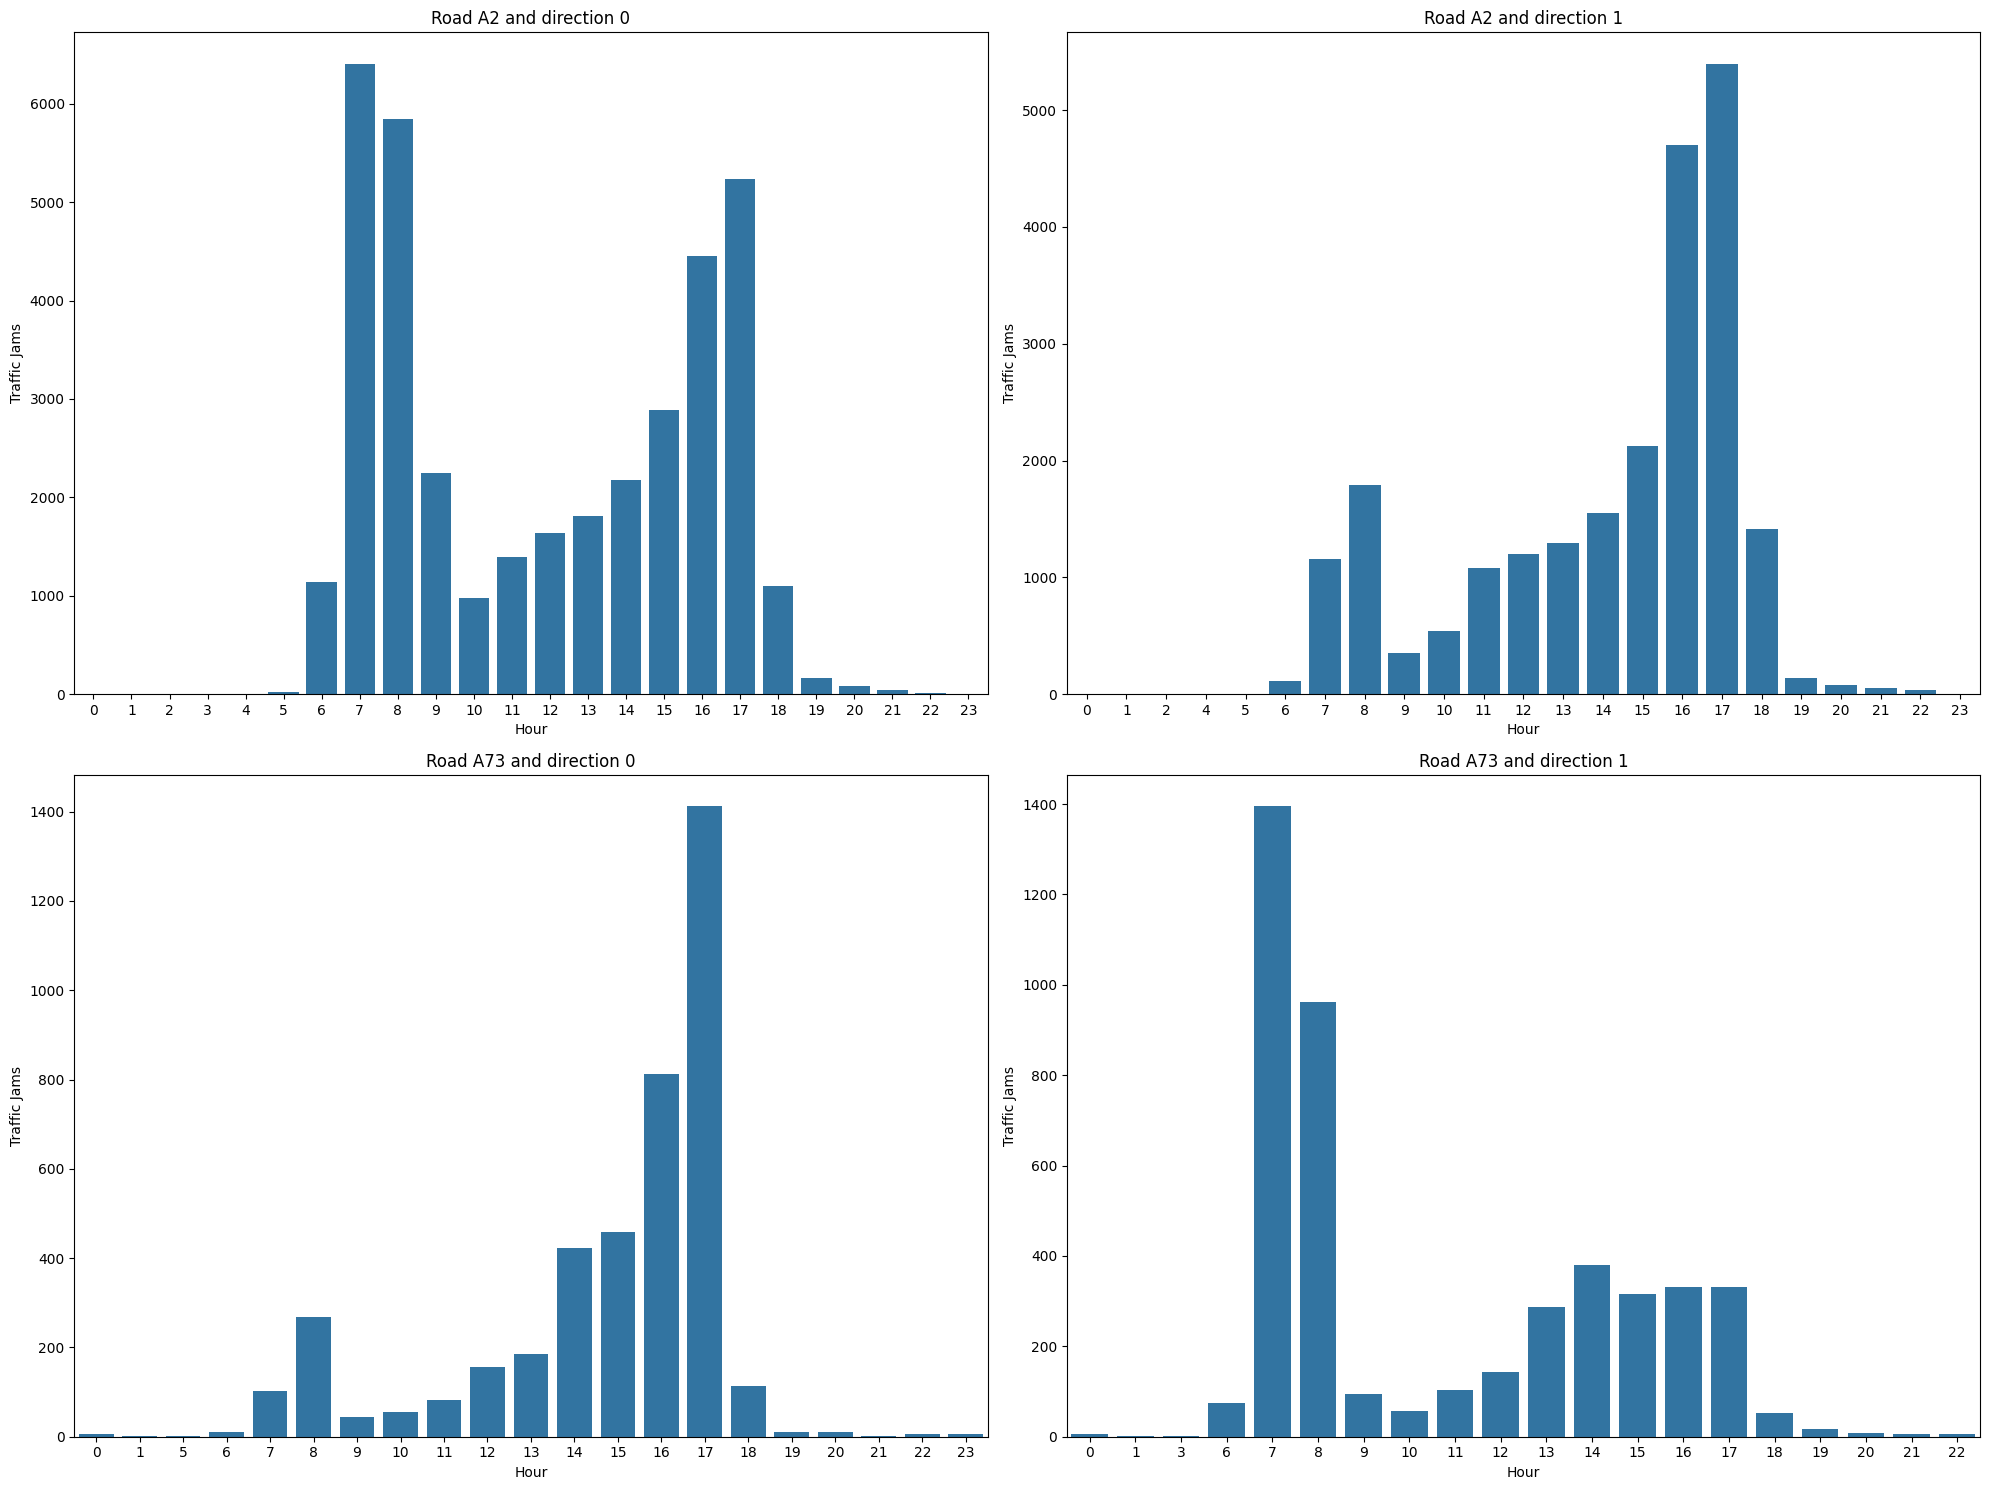

In [32]:
import seaborn as sns

actualtr0 = appended_frame[(appended_frame['Duration']!=0)&(appended_frame['HectometerDirectionNum']==0)&(appended_frame['RoadNumber']==2)]
actualtr0 = actualtr0['Hour'].value_counts().sort_index() 

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
sns.barplot(x=actualtr0.index, y=actualtr0.values, ax = axes[0,0])
axes[0, 0].set_title('Road A2 and direction 0')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Traffic Jams')


actualtr1 = appended_frame[(appended_frame['Duration']!=0)&(appended_frame['HectometerDirectionNum']==1)&(appended_frame['RoadNumber']==2)]
actualtr1 = actualtr1['Hour'].value_counts().sort_index()

sns.barplot(x=actualtr1.index, y=actualtr1.values, ax = axes[0,1])
axes[0, 1].set_title('Road A2 and direction 1')
axes[0, 1].set_xlabel('Hour')
axes[0, 1].set_ylabel('Traffic Jams')

actualtr2 = appended_frame[(appended_frame['Duration']!=0)&(appended_frame['HectometerDirectionNum']==0)&(appended_frame['RoadNumber']==73)]
actualtr2 = actualtr2['Hour'].value_counts().sort_index() 


sns.barplot(x=actualtr2.index, y=actualtr2.values, ax = axes[1,0])
axes[1, 0].set_title('Road A73 and direction 0')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Traffic Jams')


actualtr3 = appended_frame[(appended_frame['Duration']!=0)&(appended_frame['HectometerDirectionNum']==1)&(appended_frame['RoadNumber']==73)]
actualtr3 = actualtr3['Hour'].value_counts().sort_index()

sns.barplot(x=actualtr3.index, y=actualtr3.values, ax = axes[1,1])
axes[1, 1].set_title('Road A73 and direction 1')
axes[1, 1].set_xlabel('Hour')
axes[1, 1].set_ylabel('Traffic Jams')

plt.tight_layout()
plt.show()

## Creating the category column

In [33]:
bins = [-np.inf, 0, 15, 30, np.inf]
labels = ['none', 'light', 'medium', 'heavy']
category_mapping = {'none': 0, 'light': 1, 'medium': 2, 'heavy': 3}

appended_frame['Duration Category'] = pd.cut(appended_frame['Duration'].fillna(0), bins=bins, labels=labels)
appended_frame['encoded_type'] = appended_frame['Duration Category'].map(category_mapping)
appended_frame['encoded_type'] = appended_frame['encoded_type'].astype(int)

appended_frame["Duration Category"].value_counts()

Duration Category
none      307603
light      51914
heavy       9935
medium      7579
Name: count, dtype: int64

## Adding date breakdown

### Day of the week

In [34]:
appended_frame['WeekdayName'] = appended_frame['StartDate'].dt.day_name()
appended_frame['Weekday'] = appended_frame['StartDate'].dt.weekday

### Day of the year

In [35]:
appended_frame['DayofYear'] = appended_frame['StartDate'].dt.dayofyear

### Year

In [36]:
appended_frame['Year'] = appended_frame['StartDate'].dt.year

### Day of month

In [37]:
appended_frame['DayofMonth'] = appended_frame['StartDate'].dt.day

## Modelling

### Random Forest

In [38]:
warnings.filterwarnings('ignore')
from joblib import dump
import pickle
patch_sklearn()

target = "encoded_type"
y = appended_frame[target]

features = ['Hour', 'RoadNumber', 'Weekday', 'DayofYear', 'Year', 'DayofMonth', 'HectometerDirectionNum']
X = appended_frame[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

random_forest = RandomForestClassifier(max_depth=70, min_samples_leaf=1, min_samples_split=3, n_estimators=200, bootstrap=False)
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy_percentage = math.ceil(accuracy * 100)

print(f"Accuracy: {accuracy_percentage}%")

with open("model_94.pkl", "wb") as file:
    pickle.dump(random_forest, file)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Accuracy: 93%


### Results and evaluation

#### Classification report

In [39]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     61471
           1       0.75      0.86      0.80     10402
           2       0.19      0.07      0.10      1553
           3       0.18      0.07      0.10      1981

    accuracy                           0.92     75407
   macro avg       0.52      0.49      0.49     75407
weighted avg       0.91      0.92      0.91     75407



#### Feature importances

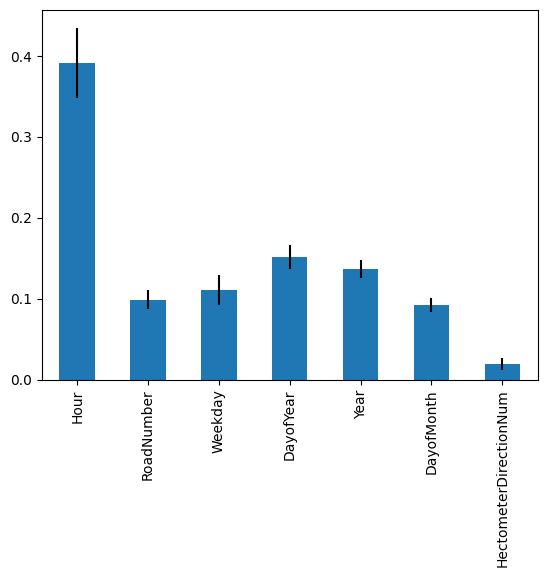

In [40]:
forest_importances = pd.Series(random_forest.feature_importances_, index=features)
standard_deviation = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)
plt.figure()
forest_importances.plot.bar(yerr=standard_deviation)
plt.show()

#### Confusion matrix

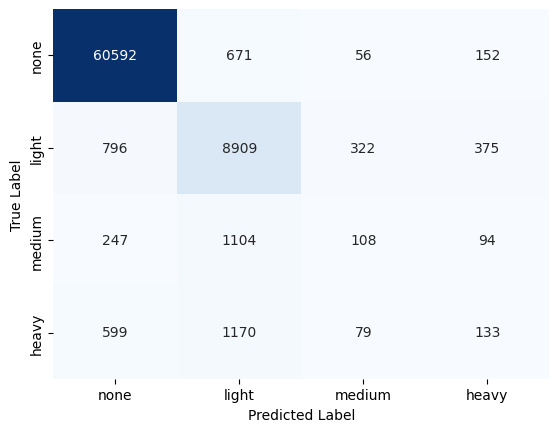

In [41]:
from sklearn.metrics import confusion_matrix
 
labels = category_mapping
 
matrix = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=None, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Cross-validation

In [42]:
warnings.filterwarnings('ignore')
patch_sklearn()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = cross_val_score(random_forest, X_train, y_train, cv=skf, scoring='accuracy')# average accuracy score
print("Accuracy scores for each fold:", accuracy_scores)
average_accuracy = accuracy_scores.mean()
print("Average accuracy score:", average_accuracy)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Accuracy scores for each fold: [0.92261915 0.92285122 0.92067965 0.92208869 0.92323122]
Average accuracy score: 0.9222939850185432


### Inference

In [43]:
warnings.filterwarnings('ignore')
today = date.today()

hour = 17
road = 2
direction = 0
weekday = today.weekday()
dayofyear = today.timetuple().tm_yday
year = today.year
dayofmonth = today.day

X_inference = pd.DataFrame([{"Hour": hour, 
                             "RoadNumber": road,
                             "Weekday": weekday,
                             "DayofYear": dayofyear,
                             "Year": year,
                             "DayofMonth": dayofmonth,
                             "HectometerDirectionNum": direction}])

prediction = random_forest.predict_proba(X_inference)

result = pd.DataFrame()
result["Probability"] = prediction[0]*100
predicted_label_index = prediction[0]
#predicted_label_name = category_mapping[predicted_label_index]

result

,Probability
0,90.5
1,9.5
2,0.0
3,0.0
